# Basic features of kCSD
In this tutorial we will cover the simplest case to test the kCSD method in 2 dimensions. The following steps, will take us through this.
1. Define a region of interest - a 2 dimensional space as the test bench
2. Using predefined test functions for the current sources, place a current source in this region
3. Place an electrode configuration in the the region of interest
4. Assuming ideal electrodes, obtain the potential generated at the electrodes due the the current sources
5. From these potentials, the electrode locations and using the default conditions obtain the current source density estimate
6. Perform cross validation to make sure the the estimate is not overfit

In [1]:
%matplotlib inline
import numpy as np
csd_at = np.mgrid[0.:1.:100j,                                                                                                                                                           
                  0.:1.:100j]
csd_x, csd_y = csd_at

### 1. Region of interest
We use the `numpy` python library, and define a 2 dimensional space using the `mgrid` function. We define the region of interest between `0` and `1` in the `xy` plane, with a resolution of `100` points in each dimension (as indicated by `100j`). The units we will assume are in $mm$. The first line starting with the `%` is to ensure the plots using this tutorial are displayed correctly.

In [2]:
from kcsd import csd_profile as CSD
CSD_PROFILE = CSD.gauss_2d_small
true_csd = CSD_PROFILE(csd_at, seed=15) 

### 2. Predefined current sources for testing
The `kcsd` library provides some test sources that can be generated on demand. This can be imported from the `csd_profile` module. This module contains some predefined current source generating functions which can be used as test sources. In this tutorial, we will use the `gauss_2d_small` function to generate a 2 dimensional gaussian small sources. The other option for the 2 dimensional sources is the `gauss_2d_large`. In order to generate the exact same source after each run, we must invoke this function using the same `seed` variable. For the sake of simplicity, these current sources are static and do not change with time. 
***
To visualize the current sources, we can display the current source density as a heatmap. Also note that changing the `seed`, or the source type to `gauss_2d_large`, changes the type of the current sources generated. The code below displays this test source as what we refer to as the True CSD. For convinience let us define this as a function `make_plot`.

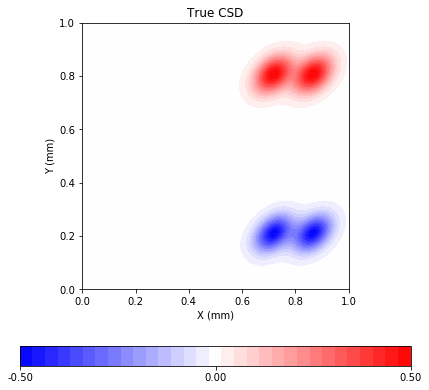

In [3]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def make_plot(xx, yy, zz, title='True CSD', cmap=cm.bwr):
    fig = plt.figure(figsize=(7, 7))
    ax = plt.subplot(111)
    ax.set_aspect('equal')
    t_max = np.max(np.abs(zz))
    levels = np.linspace(-1 * t_max, t_max, 32)
    im = ax.contourf(xx, yy, zz, levels=levels, cmap=cmap)
    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)')
    ax.set_title(title)
    ticks = np.linspace(-1 * t_max, t_max, 3, endpoint=True)
    plt.colorbar(im, orientation='horizontal', format='%.2f', ticks=ticks)
    return ax
make_plot(csd_x, csd_y, true_csd, title='True CSD', cmap=cm.bwr)

In [4]:
ele_x, ele_y = np.mgrid[0.05: 0.95: 10j,
                        0.05: 0.95: 10j]
ele_pos = np.vstack((ele_x.flatten(), ele_y.flatten())).T

### 3. Place electrodes
We now chose the positions of the electrodes within the region of interest. Once again, we obtain their positions using the `mgrid` function, and place them between `0.05` $mm$ and `0.95` $mm$ of the region of interest, with a resolution of `10` (as indicated by `10j`) in each dimensions, totalling to `100` electrodes. Notice that the electrodes do not precisely span the entire region of interest. Although this example illustrates regular spaced, the method does not require this and can handle any arbitrary distribution of electrodes.

In [5]:
from scipy.integrate import simps

def integrate_2d(csd_at, true_csd, ele_pos, h, csd_lims):
    csd_x, csd_y = csd_at
    xlin = csd_lims[0]                                                                                                                                                                                      
    ylin = csd_lims[1]                                                                                                                                                                                      
    Ny = ylin.shape[0]                                                                                                                                                                                      
    m = np.sqrt((ele_pos[0] - csd_x)**2 + (ele_pos[1] - csd_y)**2)                                                                                                           
    m[m < 0.0000001] = 0.0000001
    y = np.arcsinh(2 * h / m) * true_csd
    integral_1D = np.zeros(Ny)                                        
    for i in range(Ny):                                                  
        integral_1D[i] = simps(y[:, i], ylin)
    integral = simps(integral_1D, xlin)
    return integral

pots = np.zeros(ele_pos.shape[0])
xlin = csd_at[0, :, 0]
ylin = csd_at[1, 0, :]
h = 50.  # distance between the electrode plane and the CSD plane
sigma = 1.0 # S/m
for ii in range(ele_pos.shape[0]):                                                                                                                                                                      
    pots[ii] = integrate_2d(csd_at, true_csd,                                                                                                                                                         
                            [ele_pos[ii][0], ele_pos[ii][1]], h,                                                                                                                                      
                            [xlin, ylin])
pots /= 2 * np.pi * sigma

### 4. Compute potentials generated
At the given electrode positions, we need to evaluate the potential generated due to the current sources that were placed in step 2 (forward method). We make some assumptions regarding the location of the sources with respect to the electrode positions, given by the variable `h`. We aslo assume that the medium in between is infinite homogeneous medium whose conductivity is given by variable `sigma` and equals `1` $S/m$. We utilize the `scipy` library's `simps` function to integrate the current sources in the two dimensions to obtain the potentials -`pots`, at the electrode positions. We also assume that the electrodes are ideal, point sized and noise free.
***
To visulize the potentials, we use the potentials obtained at the electrodes positions (100 of them), and use the  `scipy` libraries `interpolate.griddata` function to extract the potentials in the plane of electrodes. While this is solely "see" the potentials. The kcsd method does only utilized the potentials recorded at the electrode postions as we shall see in the next step. We shall display this intepolated potential using a different heatmap to emphasize that the current sources and the potentials are two distinct quantities. We can also display the electrodes as a scattered points on this plot.

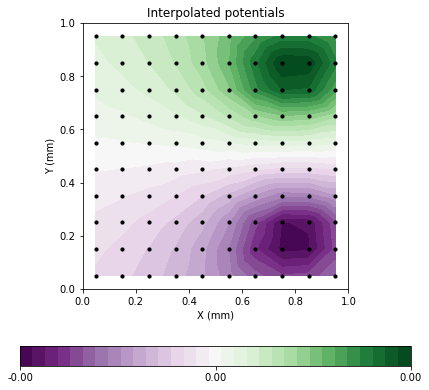

In [6]:
from scipy.interpolate import griddata

def grid(x, y, z):                                                                                                                                                                    
    x = x.flatten()                                                                                                                                                                                             
    y = y.flatten()                                                                                                                                                                                             
    z = z.flatten()                                                                                                                                                                                             
    xi, yi = np.mgrid[min(x):max(x):np.complex(0, 100),                                                                                                                                                        
                      min(y):max(y):np.complex(0, 100)]                                                                                                                                                        
    zi = griddata((x, y), z, (xi, yi), method='linear')                                                                                                                                                         
    return xi, yi, zi

pot_X, pot_Y, pot_Z = grid(ele_pos[:, 0], ele_pos[:, 1], pots)
ax = make_plot(pot_X, pot_Y, pot_Z, title='Interpolated potentials', cmap=cm.PRGn)
ax.scatter(ele_pos[:, 0], ele_pos[:, 1], 10, c='k')

In [7]:
from kcsd import KCSD2D

pots = pots.reshape((len(ele_pos), 1)) # first time point 
k = KCSD2D(ele_pos, pots, h=h, sigma=sigma,                                                                                                                                                       
           xmin=0.0, xmax=1.0,
           ymin=0.0, ymax=1.0,
           n_src_init=1000, src_type='gauss', R_init=1.)
est_csd = k.values('CSD')

### 5. kCSD method
Here we import from the `kcsd` library, the relevant method `KCSD2D` to estimate the current source density.
* We reshape the potentials so that they correspond to the first time point of the recording. In an actual recording this would be of the shape $N_{ele} \times N_{time}$, where $N_{ele}$ is the number of electrodes and $N_{time}$ is the total number of time points of recording. 
* Next, we invoke the `KCSD2D` class with the relevant parameters. The only necessary parameters that need to passed to this class are the positions of the electrodes - `ele_pos` and the potentials they see - `pots`.
* Additionally, we can also "tell" the method regarding some of the assumptions to take for the forward method by passing the variables `h` and `sigma`. 
* Similarly, that we expect the sources to lie between `xmin`,`xmax` and `ymin`,`ymax`. We also impose to try to `1000` basis functions of the type `gauss`, and to guess the initial size of the gaussian basis source `R_init` to be `1`.
* In the final step we obtain the estimated CSD by asking the method for their value and storing it.
***
We once again can visualize the estimated current source density my making a heatmap of this estimation. This must be compared to the True CSD obtained at the end of step 2. However we notice that the estimation does not resemble the current source which we are testing. Perhaps the parameters that we are passing were a bad choice. For these reasons we perform cross validation to ensure that the estimate is not being overfit. 

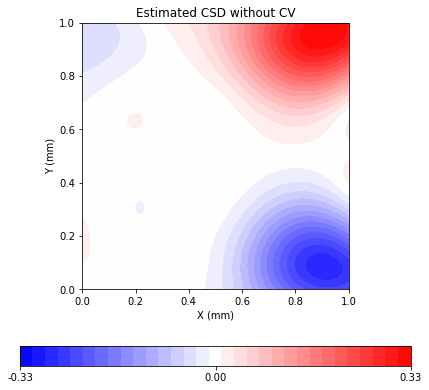

In [8]:
make_plot(k.estm_x, k.estm_y, est_csd[:, :, 0], 
          title='Estimated CSD without CV', cmap=cm.bwr) # First time point

In [9]:
k.cross_validate(Rs=np.linspace(0.01, 0.15, 15))
est_csd = k.values('CSD')

No lambda given, using defaults
Cross validating R (all lambda) : 0.01
Cross validating R (all lambda) : 0.02
Cross validating R (all lambda) : 0.03
Cross validating R (all lambda) : 0.04
Cross validating R (all lambda) : 0.05
Cross validating R (all lambda) : 0.06
Cross validating R (all lambda) : 0.07
Cross validating R (all lambda) : 0.08
Cross validating R (all lambda) : 0.09
Cross validating R (all lambda) : 0.1
Cross validating R (all lambda) : 0.11
Cross validating R (all lambda) : 0.12
Cross validating R (all lambda) : 0.13
Cross validating R (all lambda) : 0.14
Cross validating R (all lambda) : 0.15
R, lambda : 0.11 1.46779926762e-06


### 6. Cross validation
The cross validation step is a single line command that automatically perform cross validation using leave one out approach of the electrodes. Here the crossvalidation is performed for a range of `R` values which gives the size of the gaussian basis function, and the regularization parameter $\lambda$ values. At the end of the this step, we would obtain the optimal parameters that would correct for any overfitting. The outputs the progress of the crossvalidation step and displays the optimal candidates in the last line. An alternative way of finding these optimal parameters would be to utilize the L-curve method.
***
Once again, we can visualise the current source density estimation after cross validation step as a heat map. We find that the estimation of the current sources resembles the True CSD.

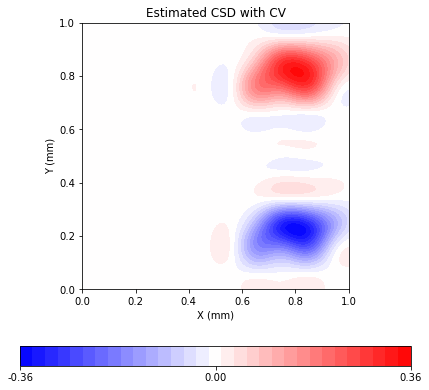

In [10]:
make_plot(k.estm_x, k.estm_y, est_csd[:, :, 0], 
          title='Estimated CSD with CV', cmap=cm.bwr) # First time point